In [1]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from xgboost import XGBRegressor


## Project Modules
import models_utils

In [2]:
## CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [3]:
## HYPERPARAMETER TUNING

def random_search(model, params, X_train, y_train, X_test, y_test):
    tscv = TimeSeriesSplit(n_splits=3)  # Use TimeSeriesSplit for better handling of time-series data
    random = RandomizedSearchCV(model, param_distributions=params, n_iter=200, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    model_random = random.fit(X_train, y_train)

    print('Best hyperparameters are: '+str(model_random.best_params_))
    print('Best score is: '+str(model_random.best_score_))

    model = model_random.best_estimator_
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print('MSE:', mse)
    print('MAE:', mae)
    return model

In [4]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)
lots.drop(columns=['Error', '0', '0.1', '0.2', '0.3', '0.4'], inplace=True)

print('Lots count:', lots.shape[0])
print('Lots columns:', lots.columns)

Lots count: 12673
Lots columns: Index(['artist_link', 'Descrição', 'Fonte de Pesquisa', 'Data da Pesquisa',
       'Type', 'Século', 'Artist', 'Título', 'url', 'Década', 'img_url',
       'Medium', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price (BRL)',
       'Price (USD)', 'Price (BRL/cm²)', 'Medium_type', 'Sold',
       'Year of sale'],
      dtype='object')


In [5]:
lots['Medium_type'].value_counts()

Medium_type
pintura       6137
desenho       2906
reprodução    2703
outro          927
Name: count, dtype: int64

In [6]:
## SELECT ARTISTS

catalogo_artists = [
    'José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti',
    'Candido Portinari (1903-1962)',
    'Di Cavalcanti (1897-1976)',
    'Alberto Guignard - Alberto da Veiga Guignard',
    'Antônio Bandeira (1922-1967)',
    'Ismael Nery',
    'Tarsila do Amaral',
    'Maria Martins',
    'Maria Leontina Franco Da Costa',
    'Djanira da Motta e Silva',
    'Ibere Camargo - Iberê Camargo',
    'Milton Dacosta',
    'Cildo Meireles (1948)',
    'Helio Oiticica - Hélio Oiticica',
    'Annita Catarina Malfatti - Anita Malfatti - Anita Malfati',
]

lots = lots[lots['Artist'].isin(catalogo_artists)]

In [7]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  5542


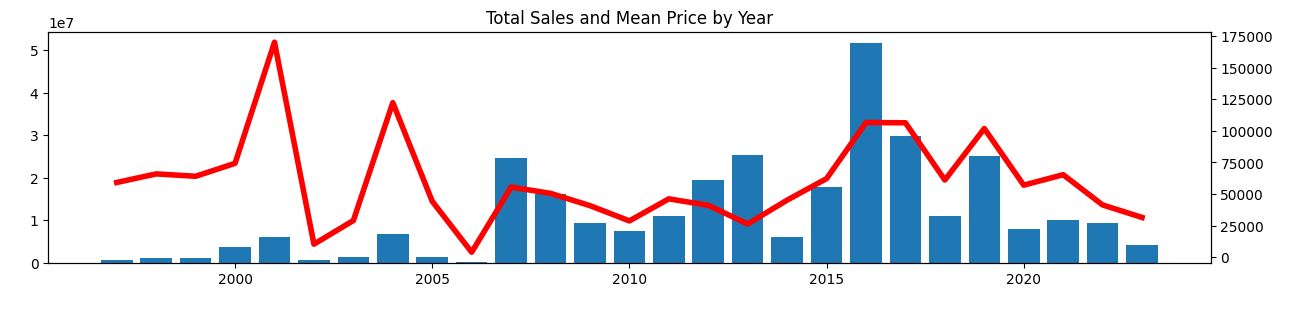

In [8]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Year of sale')['Price (BRL)'].sum())
sales['Total Sales'] = sold_lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = sold_lots.groupby('Year of sale')['Price (BRL)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [9]:
# TOP ARTISTS BY SALES COUNT

# dataframe with 2 columns: #sales, total sales ($) and mean price ($)
top_artists = pd.DataFrame(sold_lots['Artist'].value_counts())
top_artists['Total Sales'] = sold_lots.groupby('Artist')['Price (BRL)'].sum()
top_artists['Mean Price'] = sold_lots.groupby('Artist')['Price (BRL)'].mean()
# include mean area
top_artists['Mean Area'] = sold_lots.groupby('Artist')['Area (cm²)'].mean()
# mean price per area
top_artists['Mean Price per Area'] = top_artists['Mean Price'] / top_artists['Mean Area']

top_artists = top_artists.sort_values(by='Total Sales', ascending=False)
top_artists.drop('Mean Area', axis=1, inplace=True)
top_artists.head()

,count,Total Sales,Mean Price,Mean Price per Area
Artist,,,,
Alberto Guignard - Alberto da Veiga Guignard,294,60778045.0,206728.044218,29.703807
Candido Portinari (1903-1962),750,56321402.0,75095.202667,58.706394
Antônio Bandeira (1922-1967),562,44234550.0,78709.163701,44.260454
José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,280,40294220.0,143907.928571,91.336134
Di Cavalcanti (1897-1976),566,26449055.0,46729.779152,20.711885


In [10]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 750 lots for Candido Portinari (1903-1962)


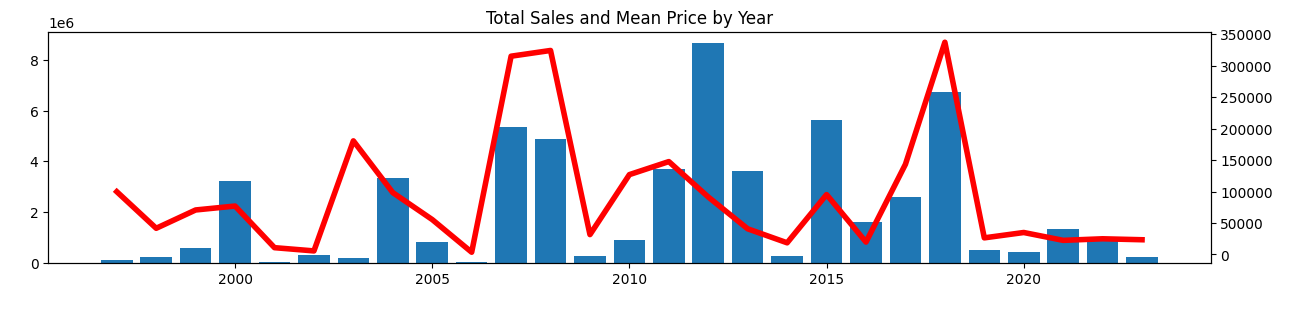

In [11]:
artist_name = 'Candido Portinari (1903-1962)'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (BRL)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (BRL)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (BRL)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [12]:
## FILL MISSING VALUES IN 'Year' COLUMN

# # print count of lots that dont have a value for 'Year
# year_missing = lots[lots['Ano'].isna()]
# print('Lots without year:', year_missing.shape[0])
# # lots without year but with década
# print('Lots with século:', year_missing[year_missing['Década'].notna()].shape[0])

In [13]:
## FIT PRICE MODELS

X_train, X_test, y_train, y_test = models_utils.get_df_to_model(lots)
models_df, models = models_utils.fit_models(X_train, y_train, X_test, y_test)

models_df

shape of lots_to_model (before split): (12220, 6)
model features: 20


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,0.295698,0.925450,0.946413,0.897570
RMSE,427920.936815,139222.083167,118035.995400,163191.195505
MAE,183671.065834,22130.072791,21877.818762,61164.074263


In [14]:
## INCLUDE PREDICTED PRICE, ACTUAL PRICE AND ERROR IN TEST SET
model = models['Random Forest']
lots_copy = models_utils.get_predicted_price_and_error(X_test, y_test, model)

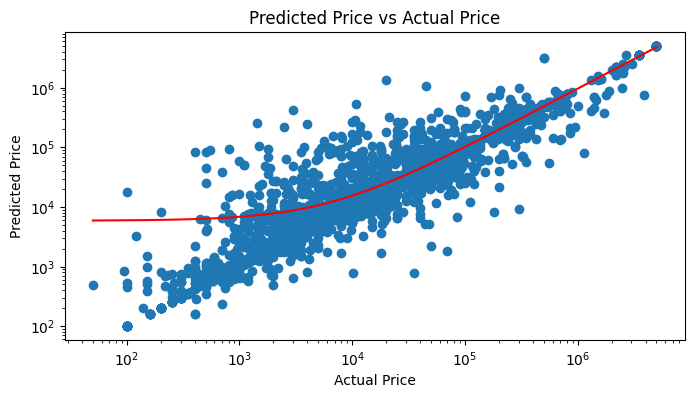

In [15]:
## COMPARE PREDICTED PRICE VS ACTUAL PRICE
models_utils.plot_predicted_vs_actual_price(lots_copy)

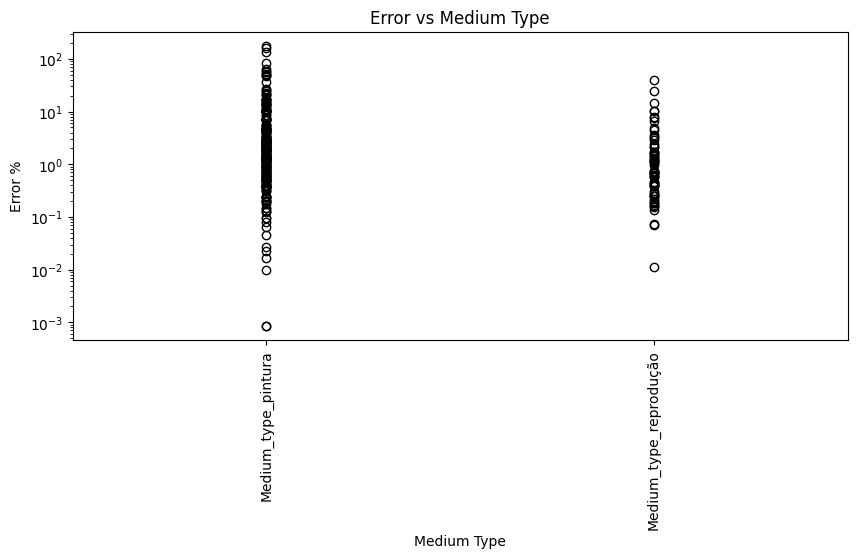

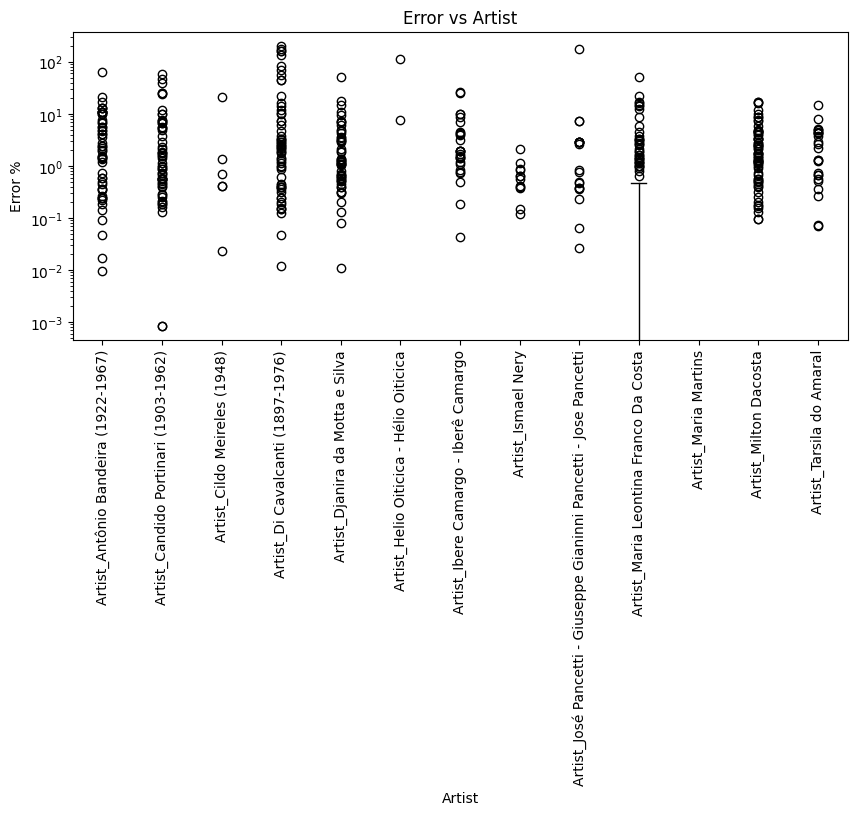

In [17]:
## COMPARE PCT ERROR ACROSS MEDIUM TYPES

medium_types = ['Medium_type_pintura', 'Medium_type_reprodução'] #, 'desenho']
artists = lots_copy.columns[1:-10]

models_utils.plot_error_by_columns(lots_copy, medium_types, 'Medium Type')
models_utils.plot_error_by_columns(lots_copy, artists, 'Artist')

In [ ]:
# show 10 biggest errors
lots_copy.sort_values('Error %', ascending=False).head(5)

,Artist_Annita Catarina Malfatti - Anita Malfatti - Anita Malfati,Artist_Antônio Bandeira (1922-1967),Artist_Candido Portinari (1903-1962),Artist_Cildo Meireles (1948),Artist_Di Cavalcanti (1897-1976),Artist_Djanira da Motta e Silva,Artist_Helio Oiticica - Hélio Oiticica,Artist_Ibere Camargo - Iberê Camargo,Artist_Ismael Nery,Artist_José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti,...,Height (cm),Medium_type_outro,Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,False,False,False,False,True,False,False,False,False,False,...,92.0,False,False,True,64.0,2013,53775.0,20.0,53755.0,2686.750000
1952.0,False,False,False,False,False,False,False,False,False,True,...,55.0,True,False,False,38.0,2018,21820.0,100.0,21720.0,216.200000
1952.0,False,False,False,False,False,False,False,False,False,True,...,55.0,True,False,False,38.0,2018,21820.0,100.0,21720.0,216.200000
1950.0,False,False,False,False,True,False,False,False,False,False,...,60.0,False,True,False,72.0,2019,262000.0,1420.0,260580.0,182.507042
NaN,False,False,False,False,False,False,False,False,False,True,...,65.0,True,False,False,46.0,2018,17750.0,100.0,17650.0,175.500000
1973.0,False,False,False,False,True,False,False,False,False,False,...,45.0,False,True,False,55.0,2013,85675.0,500.0,85175.0,169.350000
NaN,False,False,False,False,False,False,False,False,False,False,...,65.0,False,True,False,50.0,2013,67895.0,400.0,67495.0,167.737500
NaN,False,False,False,False,True,False,False,False,False,False,...,95.0,False,True,False,64.0,2017,421975.0,3000.0,418975.0,138.658333
NaN,False,False,False,False,False,False,False,True,False,False,...,123.0,False,False,True,93.0,2022,269535.0,3600.0,265935.0,72.870833


In [ ]:
## SAVE LOCALLY MODEL AND X_TEST

# # save model to models folder
# model = xgb_model
# with open('./models/catalogo_xgb_model.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # save X_test as csv
# X_test.to_csv('./models/catalogo_X_test.csv', index=False)